In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def joined_df():
    df = pd.read_csv("dataset\\train.csv", parse_dates=['date'])
    stores_df = pd.read_csv("dataset\\stores.csv").set_index('store_nbr')
    return df.join(stores_df, on='store_nbr')


In [2]:
# - - - Time series setup - - -

df = pd.read_csv("dataset\\train.csv", parse_dates=['date'])
df['time'] = (df['date'] - df['date'].min()).dt.days
# data = df.copy()

# data = data.drop(['store_nbr'], axis=1).groupby(['family', 'time']).sum(['sales'])

sales_per_day = df.copy()[['time', 'sales']]
sales_per_day.dropna(inplace=True)
sales_per_day = sales_per_day.groupby(['time']).sum(['sales'])
print(sales_per_day.info)

plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(30, 20))

""""""

<bound method DataFrame.info of               sales
time               
0       2511.618999
1     496092.417944
2     361461.231124
3     354459.677093
4     477350.121229
...             ...
1683  826373.722022
1684  792630.535079
1685  865639.677471
1686  760922.406081
1687  762661.935939

[1684 rows x 1 columns]>


''

<Figure size 2160x1440 with 0 Axes>

KeyError: 'time'

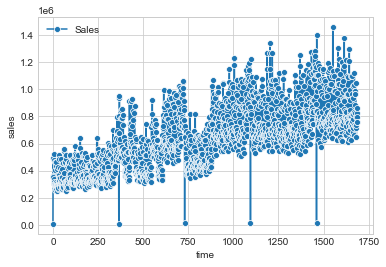

In [3]:
# - - - Plot series and linear regression - - -

fig, ax = plt.subplots()

"""
families = df['family'].unique()
data['time'] = data.index.get_level_values('time')
for family in families[0:4]:
    fam_df = data.iloc[data.index.get_level_values('family') == family]
    fam_df['date_'] = fam_df.index.get_level_values('time')
    sns.lineplot(data=fam_df, x="date_", y="sales", ax=ax, marker='o', linestyle='-', label=family)
    sns.regplot(data=fam_df, x='date_', y='sales', ax=ax, fit_reg=True, ci=None, label=f'lr: {family}')
"""
sns.lineplot(data=sales_per_day, x="time", y="sales", ax=ax, marker='o', linestyle='-', label='Sales')
sns.regplot(data=sales_per_day, x='time', y='sales', ax=ax, fit_reg=True, ci=None, label='Linear Reg.')

plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')

ax.legend()
plt.show()
""""""

In [ ]:

# - - - TREND (ma penso si a fatto male) - - -
""""""
# Moving Average per mese, per settimana
moving_average_monthly = sales_per_day.copy()
moving_average_monthly['sales'] = moving_average_monthly['sales'].rolling(
    window=28,        # 4 weeks window
    center=True,      # puts the average at the center of the window
    min_periods=14,   # TIP: choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

moving_average_weekly = sales_per_day.copy()
moving_average_weekly['sales'] = moving_average_weekly['sales'].rolling(
    window=7,        # 4 weeks window
    center=True,      # puts the average at the center of the window
    min_periods=4,   # TIP: choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

print(sales_per_day.info)

fig, ax = plt.subplots()

sns.lineplot(x='time', y='sales', data=sales_per_day, ax=ax)
sns.lineplot(x='time', y='sales', data=moving_average_weekly, ax=ax)
sns.lineplot(x='time', y='sales', data=moving_average_monthly, ax=ax)

ax.legend()
plt.show()
""" """

In [ ]:
# - - - Linear Regression - - -

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess

fig, ax = plt.subplots()
sns.lineplot(x='time', y='sales', data=sales_per_day, ax=ax)

for i in range(5):
    dp = DeterministicProcess(
        index=sales_per_day.index,      # dates from the training data
        constant=True,       # dummy feature for the bias (y_intercept)
        order=i,             # the time dummy (trend)
        drop=True,           # drop terms if necessary to avoid collinearity
    )
    # `in_sample` creates features for the dates given in the `index` argument
    X = dp.in_sample()
    y = sales_per_day['sales']                                   # TODO grouping with 'family'?

    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    sales_pred = sales_per_day.copy()
    sales_pred['sales'] = model.predict(X)

    label = f'Trend: {i}' if i > 0 else 'Mean'
    sns.lineplot(x='time', y='sales', data=sales_pred, ax=ax, label=label)
ax.legend()
plt.show()
""""""

In [ ]:
# +*+*+ SEASONALITY +*+*+
from statsmodels.tsa.seasonal import seasonal_decompose

# may prefer interpolation instead of dropping nulls
# df = df.interpolate(method='bfill')
for i in [10, 20, 30, 40, 52, 60, 80, 100]:
    decompose_result_mult = seasonal_decompose(sales_per_day,  # eventually add ['sales']
        model="multiplicative", period=i)           # o additive, TODO modificare period?

    trend = decompose_result_mult.trend
    seasonal = decompose_result_mult.seasonal
    residual = decompose_result_mult.resid
    decompose_result_mult.plot()
    plt.show()

In [ ]:
# ======================================================================
# =#=#= A*R*I*M*A =#=#=
# ======================================================================


# **> ADF test <**
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA as arima

time_series = sales_per_day.copy()['sales']

def perform_adf_test(series):
    # Return val
    not_stationary = True
    # Perform ADF test
    result = adfuller(series)
    adf_statistic, p_value, _, _, critical_values, _ = result

    print()
    # Print ADF test results
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')

    # Check the p-value
    if p_value <= 0.05:
        print("Reject the null hypothesis. The data is stationary.")
        not_stationary = False
    else:
        print("Fail to reject the null hypothesis. The data is non-stationary.")
    return not_stationary


d = 0
not_stationary = perform_adf_test(time_series)
print('\n')
while not_stationary:
    d += 1
    time_series = time_series.diff().dropna()
    not_stationary = perform_adf_test(time_series)
    print('\n')

print(f"Value of parameter d: {d}")

In [ ]:
# **> Autocorrelazione (k,q) <**
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 6))
plt.title('Lag Plot')
pd.plotting.lag_plot(time_series, lag=1, ax=ax1)
pd.plotting.lag_plot(time_series, lag=2, ax=ax2)
pd.plotting.lag_plot(time_series, lag=3, ax=ax3)
pd.plotting.lag_plot(time_series, lag=4, ax=ax4)
plt.show()

df1 = sales_per_day['sales'].copy()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 6))
plt.title('Lag Plot NON DIFF')
pd.plotting.lag_plot(df1, lag=10, ax=ax1)
pd.plotting.lag_plot(df1, lag=20, ax=ax2)
pd.plotting.lag_plot(df1, lag=30, ax=ax3)
pd.plotting.lag_plot(df1, lag=40, ax=ax4)
plt.show()

plot_acf(time_series)
plt.title('Autocorrelation Plot')
plt.show()

In [ ]:
# Plot partial autocorrelation #todo set lag corretto

# for LAG in [5, 10, 20, 30, 40, 50]:
LAG=20
plot_pacf(time_series, lags=LAG)
plt.title(f'Partial Autocorrelation Plot - LAG: {LAG}')
plt.show()

In [ ]:
# - - - Test statistici per vari set di parametri di ARIMA - - -
def arima_fit(time_series, p=1, d=1, q=1):
    # Fit ARIMA model
    arima_model = arima(time_series, order=(p, d, q))  # Example order, adjust as needed
    arima_results = arima_model.fit()

    print(arima_results.summary())

for d in range(2):
    for p in range(3):
        for q in range(3):
            arima_fit(df1, p, d, q)

In [ ]:
# - - - AUTO_ARIMA - - -
from pmdarima import auto_arima

auto_fit = auto_arima(df1, start_p=0, start_q=0,
                          max_p=2, max_q=2,
                          m=1,                     #TODO m is used for seasonality, m=1 means no seasonality (cover this later)
                          seasonal=False,          # We do not want seasonality here
                          d=None,                  # The order of first-differencing. If None (by default), automatically be selected
                          trace=True,
                          #error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

auto_fit.summary()


